In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as utils
import torch.utils.data as td
torch.manual_seed(1234)
import pandas as pd
from sklearn.model_selection import train_test_split
#from sklearn.datasets import load_iris

In [2]:
#Custom Model
class IrisNet1(nn.Module):

    def __init__(self,input_size,h1,h2,output):
        super(IrisNet1, self).__init__()
   
        self.fc1   = nn.Linear(input_size, h1)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Linear(h1, h2)
        self.relu2 = nn.ReLU()
        self.fc3   = nn.Linear(h2,output)    

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        
        return out  

In [3]:
# Hyperparameters

learning_rate = 0.01
learning_momentum = 0.9
input_size=12
h1=25
h2=14
output=2
epochs = 20

# Create the Model

model = IrisNet1(input_size,h1,h2,output)

In [4]:
#Choose Optimizer and Loss function

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=learning_momentum)

In [5]:
#load dataset
bank=pd.read_csv('E:\\M.tech_Projects\\Deep Neural Network\\Datasets\\Bank_Exit.csv')
#display(bank)

In [6]:
#Pick out relevant columns
bank1 = bank.drop(['RowNumber', 'Cust_ID','Name','Country'], axis=1)
#bank1.head()

In [7]:
dummy = pd.get_dummies(bank['Country'])
#dummy.head()

In [8]:
bank1 = pd.concat([bank1, dummy], axis=1)
#display(bank1)

In [9]:
y = bank1.Exit
x = bank1.drop('Exit', axis =1 )

In [10]:
#load dataset
#iris=load_iris()
#x,y=iris.data,iris.target
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)
x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5,random_state=1)

In [11]:
display(x_train.shape)
display(x_test.shape)
display(x_val.shape)
display(y_train.shape)
display(y_test.shape)
display(y_val.shape)

(7992, 12)

(999, 12)

(999, 12)

(7992,)

(999,)

(999,)

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

In [13]:
import numpy as np
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [14]:
# Create DataLoaders

# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = utils.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=10,shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = utils.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=10, shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
val_x = torch.Tensor(x_val).float()
val_y = torch.Tensor(y_val).long()
val_ds = utils.TensorDataset(val_x,val_y)
val_loader = td.DataLoader(val_ds, batch_size=10, shuffle=True, num_workers=1)

print("Loaders ready")

Loaders ready


In [15]:
# Function to Train the model

def train(model, data_loader, data_loader1, criterion,optimizer):
    model.train()
    train_loss = 0
    valid_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        train_loss += loss.item()
        # backpropagate
        loss.backward()
        optimizer.step()
        #train_loss += loss.item()
## evaluation part 
    model.eval()
    for batch1, tensor1 in enumerate(data_loader1):
        data1, target1 = tensor1
        output = model(data1)
        loss1 = criterion(output, target1)
        valid_loss += loss1.item()
        
        
    #Return loss
    avg_loss = train_loss / len(data_loader.dataset)
    avg_loss1 = valid_loss/len(data_loader1.dataset)
    return avg_loss, avg_loss1

In [16]:
len(val_loader.dataset)

999

In [17]:
def test(model, data_loader,criterion):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch, tensor in enumerate(data_loader):
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += criterion(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
            
    # return validation loss and prediction accuracy for the epoch
    avg_accuracy = correct / len(data_loader.dataset)
    avg_loss = test_loss / len(data_loader.dataset)
    
    return avg_loss, avg_accuracy

In [18]:
#Train the model - track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []


# Train over set epochs

for epoch in range(1, epochs + 1):
    
    # Feed the training data into the model to optimize the weights
    train_loss,valid_loss = train(model, train_loader,val_loader, criterion, optimizer)
    
    # Log the metrcs for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(valid_loss)
    
    # Print stats for every 10th epoch so we can see training progress
    if (epoch) % 1 == 0:
        print('Epoch {:d}: Training loss= {:.4f}, Validation loss= {:.4f}'.format(epoch, train_loss, valid_loss))

Epoch 1: Training loss= 0.0422, Validation loss= 0.0394
Epoch 2: Training loss= 0.0359, Validation loss= 0.0362
Epoch 3: Training loss= 0.0350, Validation loss= 0.0361
Epoch 4: Training loss= 0.0345, Validation loss= 0.0356
Epoch 5: Training loss= 0.0341, Validation loss= 0.0349
Epoch 6: Training loss= 0.0340, Validation loss= 0.0358
Epoch 7: Training loss= 0.0339, Validation loss= 0.0353
Epoch 8: Training loss= 0.0336, Validation loss= 0.0346
Epoch 9: Training loss= 0.0334, Validation loss= 0.0344
Epoch 10: Training loss= 0.0334, Validation loss= 0.0350
Epoch 11: Training loss= 0.0333, Validation loss= 0.0354
Epoch 12: Training loss= 0.0330, Validation loss= 0.0348
Epoch 13: Training loss= 0.0330, Validation loss= 0.0340
Epoch 14: Training loss= 0.0330, Validation loss= 0.0350
Epoch 15: Training loss= 0.0328, Validation loss= 0.0348
Epoch 16: Training loss= 0.0326, Validation loss= 0.0358
Epoch 17: Training loss= 0.0326, Validation loss= 0.0365
Epoch 18: Training loss= 0.0326, Validat

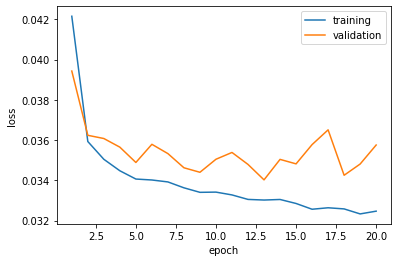

In [23]:
#Training and Validation Loss
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [20]:
# Learned Weights and Biases
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

fc1.weight 
 [[ 1.02072572e-02 -2.49030665e-02 -3.00564677e-01  2.64528245e-02
  -4.93601829e-01  1.21913940e-01 -5.02565742e-01  1.50571078e-01
   3.89186181e-02 -3.75389189e-01  2.66738236e-01  2.55696416e-01]
 [-4.11263146e-02  4.51394230e-01 -8.70210767e-01  4.73666377e-02
  -5.20735562e-01 -1.60372406e-01  8.82211328e-02  1.45516604e-01
   6.27584755e-02 -2.35922918e-01  4.63639386e-02  2.71068439e-02]
 [ 4.11214769e-01 -1.54997446e-02 -2.39469837e-02  2.04528764e-01
   1.44327641e-01 -8.34108055e-01 -2.10929707e-01 -1.34795621e-01
   1.49018884e-01  1.23192236e-01 -1.22640252e-01 -2.68940963e-02]
 [-1.09611377e-02 -4.51839380e-02 -1.50589630e-01 -6.02980377e-03
  -1.38838470e+00 -1.66931200e+00  1.40558491e-02  7.03715310e-02
   1.09693606e-03 -4.05226529e-01  4.40857202e-01 -1.34337962e-01]
 [ 2.88457274e-01  3.75889167e-02  2.57496864e-01  2.96666324e-01
   3.93969566e-01  4.19062048e-01  1.71792820e-01 -1.76403031e-01
  -5.11230946e-01 -3.69953901e-01  1.28825121e-02  1.815204

   4.84572724e-02]]
fc2.bias 
 [ 0.01260262 -0.08565702 -0.2529659   0.3865987  -0.17958122 -0.8464944
  0.12035268 -0.07215412  0.12903762 -0.27588287 -0.06357203 -0.10875456
  1.2985299  -0.59048784]
fc3.weight 
 [[ 0.24392018 -0.43497086 -0.08603864 -0.25516057  0.13950694 -0.6899831
   0.44354698  0.02229071  0.1812639  -0.42035258 -0.35514212  0.02070064
   0.29948935  0.22233588]
 [-0.30448195 -0.04073517  0.16742332  0.2887204   0.22845195  0.5218755
  -0.0827741  -0.28110895 -0.3799019   0.6794317   0.14062358  0.17422727
  -0.27951568 -0.55516434]]
fc3.bias 
 [ 0.29445547 -0.20211247]


In [21]:
test_loss, accuracy = test(model, test_loader,criterion)

In [22]:
 print('Test loss= {:.4f}, Accuracy={:.4%}'.format(test_loss, accuracy))

Test loss= 0.0358, Accuracy=85.5856%
